In [14]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
from tqdm import tqdm
warnings.filterwarnings('ignore')
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [15]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))
cuda =torch.cuda.is_available()
print(cuda)

Current Working Directory: progettoVIPM
True


In [16]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset
from utils.fine_tune_pytorch import train_model, eval_model_on_test_loader
from utils.fine_tune_pytorch import fine_tune_network_layers, eval_model_on_test_set, train_model
from copy import deepcopy
from utils.loadersAndEnums import dataloader_stratified_kfold, separate_data_based_on_class_group
from utils.extractNeuralFeatures import extract_features, extract_features_from_dataloader
from IPython.display import clear_output

In [ ]:
chosen_net = networks.GOOGLENET
print(chosen_net)

networks.RESNET50


AttributeError: 'ResNet' object has no attribute 'features'

In [5]:

in_channel = 3
num_classes = 251
learning_rate = 1e-3
batch_size = 128
num_epochs = 10

k_for_accuracy = 5

In [5]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu

linear_layers_to_remove = 1
X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers, modified_net = extract_features(train_set=datasets.TRAINING_80,
                                                                                            test_set=datasets.VALIDATION_20,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=linear_layers_to_remove, 
                                                                                            cuda=cuda)
print("Original classification layers:{}".format(chosen_net.value[1].fc))
print("---------------------------------------------------------------------------------")
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Found an existing set of features in: ./Storage/neural_features/Train_GoogLeNet_minus1_training_set_80%.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 4016
Feature vector shape of Train: (4016, 1024)
Label vector shape of Train: (4016,)
---------------------------------------------------------------------------------
Found an existing set of features in: ./Storage/neural_features/Test_GoogLeNet_minus1_train_set.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 1004
Feature vector shape of Test: (1004, 1024)
Label vector shape of Test: (1004,)
---------------------------------------------------------------------------------
Original classification layers:Linear(in_features=1024, out_features=1000, bias=True)
-----------------------------------------------

In [10]:
for param in fine_tune_layers.parameters():
    print(param.requires_grad)
    
loss_function = torch.nn.CrossEntropyLoss()

model = deepcopy(fine_tune_layers)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

n_epochs = 100
batch_size = 64
k_for_accuracy = 5

stratified_kFold = False

if stratified_kFold:
    dataloaders = dataloader_stratified_kfold(dataset=datasets.TRAINING_80, k=5, network_input_size=227, batch_size=1, shuffle=False, cuda=True, transform=None, y_cuda=None)
    trained_models = []
    models_losses = []
    models_accuracies = []
    models_k_accuracies = []
    i = 0
    for train_val_loader in dataloaders:
        clear_output()
        print("-------------------Training on {} fold-------------------".format(i+1))
        train_loader = train_val_loader[0]
        val_loader = train_val_loader[1]
        x_train, y_train = extract_features_from_dataloader(loader=train_loader, out_features = 4096,transfer_network=modified_net, dataset_type="labelled")
        x_val, y_val = extract_features_from_dataloader(loader=val_loader, out_features = 4096,transfer_network=modified_net, dataset_type="labelled")
        
        fold_net = deepcopy(model)

        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
        trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda=cuda, model=fold_net, x_train =x_train, y_train=y_train, n_epochs=n_epochs,
                                                                                 batch_size=batch_size,loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)
        # trained_models[i] = trained_model
        # models_losses[i] = losses
        # models_accuracies[i] = accuracies
        # models_k_accuracies[i] = k_accuracies
        trained_models.append(trained_model)
        models_losses.append(losses)
        models_accuracies.append(accuracies)
        models_k_accuracies.append(k_accuracies)
        i += 1
        print("---------------------------------------------------------")
else:
    trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda, model=model, x_train=X_train_ale_t.cuda(), y_train=y_train, n_epochs=n_epochs,
                                                 batch_size=batch_size, loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)


True
True
True
True
------------------Layers to fine-tune------------------
Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=251, bias=True)
)
-------------------------------------------------------
EPOCH 1:
---------------------Training---------------------
Batch 10 di 57
Batch 20 di 57
Batch 30 di 57
Batch 40 di 57
Batch 50 di 57
Training Loss: 5.524625895316141, Accuracy: 0.4149377593360996%, 5-Accuracy: 2.295988934993084%
--------------------------------------------------
--------------------Validation--------------------
Validation Loss: 5.510420731135777, Accuracy: 0.49875311720698257%, 5-Accuracy: 1.9950124688279303%
EPOCH 2:
---------------------Training---------------------
Batch 10 di 57
Batch 20 di 57
Batch 30 di 57
Batch 40 di 57
Batch 50 di 57
Training Loss: 5.467304547627767, Accuracy: 1.7704011065006915%, 5-Accuracy: 7.911479944674966%
--------------------------------------------------
----

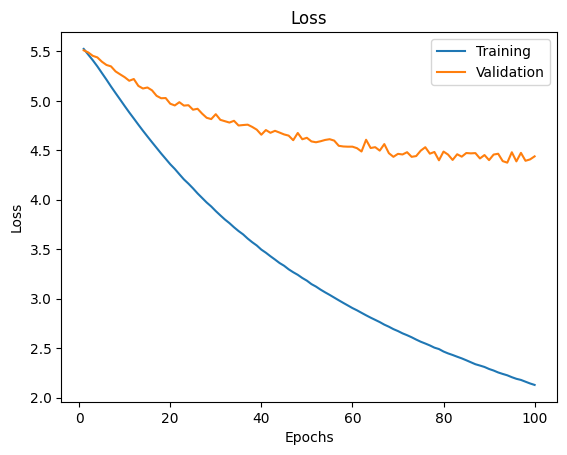

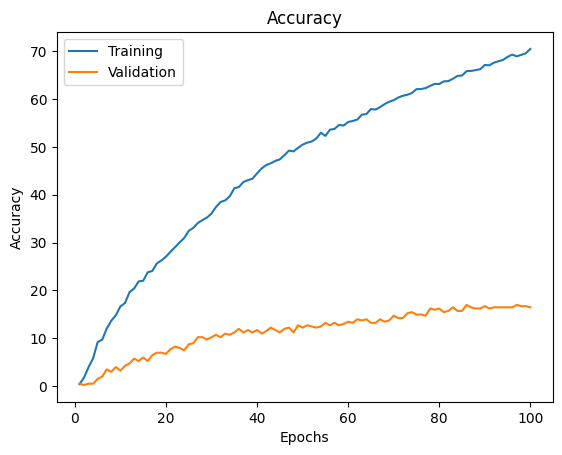

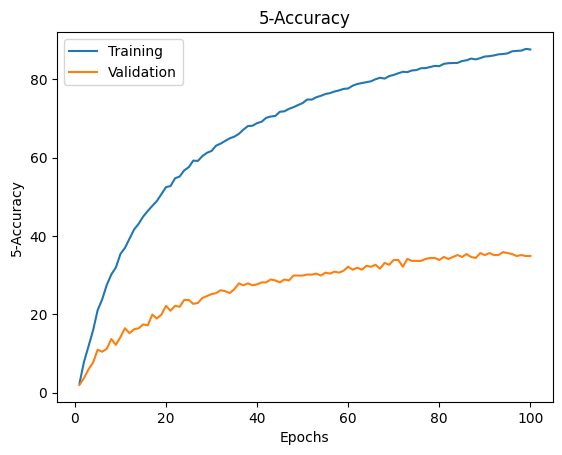

In [11]:

def plot(history, type, model_name):
  x_plot = list(range(1,len(history)+1))
  plt.figure()
  plt.title(type)
  plt.xlabel('Epochs')
  plt.ylabel(type)
  plt.plot(x_plot, history[:,0])
  plt.plot(x_plot, history[:,1])
  plt.legend(['Training', 'Validation'])
  plt.savefig("./Transfer_Learning/models_plots/GoogLeNet/{}_{}.png".format(type,model_name))

# print(losses)
if stratified_kFold:
  for i in range(5):
    model_name = "{}e_{}bsize80_20_split_fold{}".format(n_epochs, batch_size, i+1)
    plot(models_losses[i], "Loss", model_name=model_name)
    plot(models_accuracies[i], "Accuracy", model_name=model_name)
    plot(models_k_accuracies[i], f"{k_for_accuracy}-Accuracy", model_name=model_name)
else:
  model_name = "{}e_{}bsize_80_20_split".format(n_epochs, batch_size)
  plot(losses, "Loss", model_name=model_name)
  plot(accuracies, "Accuracy", model_name=model_name)
  plot(k_accuracies, f"{k_for_accuracy}-Accuracy", model_name=model_name)

In [13]:
extra = [False, "mixed_dataset"]
if stratified_kFold:
  for i in range(5):
    print("model of fold: {}".format(i+1))
    model_name = "finetunedGoogLeNet_minus{}_{}e_{}bsize_80_20_split_fold{}".format(linear_layers_to_remove, n_epochs, batch_size, i+1)
    if extra[0]:
        model_name += extra[1]
    cm = eval_model_on_test_set(trained_models[i], model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
else:
  model_name= "finetunedGoogLeNet_minus{}_{}e_{}bsize_80_20_split".format(linear_layers_to_remove, n_epochs, batch_size)
  if extra[0]:
        model_name += extra[1]
  cm = eval_model_on_test_set(trained_model, model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
  np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
  print("CM filename: {}".format("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name)))
  torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
  print("Model saved at: {}".format("./Storage/models/Neural_models/{}.pth".format(model_name)))

100%|██████████| 1004/1004 [00:00<00:00, 1050.50it/s]

Accuracy: 17.131474103585656 %
5-Accuracy: 37.05179282868526
CM filename: ./Transfer_Learning/model_metrics/ConfM_finetunedGoogLeNet_minus1_100e_64bsize_80_20_split.npy
Model saved at: ./Storage/models/Neural_models/finetunedGoogLeNet_minus1_100e_64bsize_80_20_split.pth


In [26]:
uova_pesce, pasta_riso, carne_pollo, torte, dolci, panini_tacos, altro = separate_data_based_on_class_group(X_train_ale_n, y_train)

lista_dati = [[uova_pesce, "uova_pesce"],
              [pasta_riso, "pasta_riso"],
              [carne_pollo, "carne_pollo"],
              [torte, "torte"],
              [dolci, "dolci"],
              [panini_tacos, "panini_tacos"],
              [altro, "altro"]]

In [41]:
for dato in lista_dati:
  loss_function = torch.nn.CrossEntropyLoss()

  model = deepcopy(fine_tune_layers)

  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  stratified_kFold = False
  n_epochs = 80
  batch_size = 128
  k_for_accuracy = 5

  x = torch.from_numpy(dato[0][0]).cuda()
  y = torch.from_numpy(dato[0][1]).cuda()
  trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda, model=model, x_train=x, y_train=y, n_epochs=n_epochs,
                                                  batch_size=batch_size, loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)


  def plot(history, type, model_name):
    x_plot = list(range(1,len(history)+1))
    plt.figure()
    plt.title(type)
    plt.xlabel('Epochs')
    plt.ylabel(type)
    plt.plot(x_plot, history[:,0])
    plt.plot(x_plot, history[:,1])
    plt.legend(['Training', 'Validation'])
    plt.savefig("./Transfer_Learning/models_plots/GoogLeNet/{}_{}.png".format(type,model_name))

  # print(losses)
  model_name = "{}_".format(dato[1])
  if stratified_kFold:
    for i in range(5):
      model_name += "{}e_80_20_split_fold{}".format(n_epochs, i+1)
      plot(models_losses[i], "Loss", model_name=model_name)
      plot(models_accuracies[i], "Accuracy", model_name=model_name)
      plot(models_k_accuracies[i], f"{k_for_accuracy}-Accuracy", model_name=model_name)
  else:
    model_name += "{}e_80_20_split".format(n_epochs)
    plot(losses, "Loss", model_name=model_name)
    plot(accuracies, "Accuracy", model_name=model_name)
    plot(k_accuracies, f"{k_for_accuracy}-Accuracy", model_name=model_name)

  extra = [False, "mixed_dataset"]

  torch.save(trained_model, "./Storage/models/Neural_models/{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format(dato[1],linear_layers_to_remove, n_epochs))

------------------Layers to fine-tune------------------
Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=251, bias=True)
)
-------------------------------------------------------
EPOCH 1:
---------------------Training---------------------
Training Loss: 5.5324732780456545, Accuracy: 0.1652892561983471%, 5-Accuracy: 1.6528925619834711%
--------------------------------------------------
--------------------Validation--------------------
Validation Loss: 5.502739429473877, Accuracy: 0.0%, 5-Accuracy: 7.462686567164179%
EPOCH 2:
---------------------Training---------------------
Training Loss: 5.465254592895508, Accuracy: 1.6528925619834711%, 5-Accuracy: 6.776859504132231%
--------------------------------------------------
--------------------Validation--------------------
Validation Loss: 5.427999973297119, Accuracy: 2.985074626865672%, 5-Accuracy: 14.925373134328359%
EPOCH 3:
---------------------Training--

In [43]:
from utils.fine_tune_pytorch import eval_ensamble_on_test_set
n_epochs = 80
batch_size = 128
k_for_accuracy = 5
linear_layers_to_remove = 1

In [49]:
general_model_name = "./Storage/models/Neural_models/"
pasta_riso = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("pasta_riso",linear_layers_to_remove, n_epochs)
uova_pesce = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("uova_pesce",linear_layers_to_remove, n_epochs)
carne_pollo = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("carne_pollo",linear_layers_to_remove, n_epochs)
torte = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("torte",linear_layers_to_remove, n_epochs)
dolci = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("dolci",linear_layers_to_remove, n_epochs)
panini_tacos = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("panini_tacos",linear_layers_to_remove, n_epochs)
altro = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("altro",linear_layers_to_remove, n_epochs)

pasta_riso_model = torch.load(pasta_riso)
uova_pesce_model = torch.load(uova_pesce)
carne_pollo_model = torch.load(carne_pollo)
torte_model = torch.load(torte)
dolci_model = torch.load(dolci)
panini_tacos_model = torch.load(panini_tacos)
altro_model = torch.load(altro)

ensamble_model = [pasta_riso_model,
                  uova_pesce_model,
                  carne_pollo_model,
                  torte_model,
                  dolci_model,
                  panini_tacos_model,
                  altro_model]

cm = eval_ensamble_on_test_set(ensamble_model, "prova", "Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy=k_for_accuracy)

100%|██████████| 1004/1004 [00:01<00:00, 539.28it/s]

Accuracy: 0.12649402390438247


In [13]:
if stratified_kFold:
  for i in range(5):
    print("model of fold: {}".format(i+1))
    model_name = "finetunedGoogLeNet_{}e_80_20_split_fold{}".format(num_epochs, i+1)
    cm = eval_model_on_test_loader(trained_models[i], model_name=model_name, target_dir="Transfer_Learning", test_loader=test_loader, cuda=cuda, k_for_accuracy = k_for_accuracy)
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
else:
  cm = eval_model_on_test_loader(trained_model, model_name="GoogLeNet_{}_epoch".format(num_epochs), target_dir="Transfer_Learning", test_loader=test_loader, cuda=cuda, k_for_accuracy = k_for_accuracy)
  torch.save(trained_model, "./Storage/models/Neural_models/finetunedGoogLeNet_{}e_80_20_split.pth".format(num_epochs))

100%|██████████| 1004/1004 [00:22<00:00, 44.88it/s]


Accuracy: 0.1454183266932271
10-Accuracy: 44.9203187250996


In [13]:
cm = eval_model_on_test_loader(trained_model, model_name="Alexnet", target_dir="Transfer_Learning", test_loader=test_loader, cuda=cuda)
torch.save(trained_model, "finetunedGoogLeNet.pth")

100%|██████████| 94/94 [17:18<00:00, 11.04s/it]


UnboundLocalError: cannot access local variable 'y_test' where it is not associated with a value

In [23]:
net = (torch.load("finetunedGoogLeNet.pth"))
cm = eval_model_on_test_loader(net, model_name="GoogLeNet_10_epochs", target_dir="Transfer_Learning", test_loader=test_loader, cuda=cuda)


100%|██████████| 11994/11994 [05:24<00:00, 36.94it/s]

Accuracy: 0.17525429381357346


In [ ]:
net = deepcopy(fine_tune_layers)

stratified_kFold = False

if stratified_kFold:
    dataloaders = dataloader_stratified_kfold(dataset=datasets.TRAINING_80, k=5, network_input_size=227, batch_size=1, shuffle=False, cuda=True, transform=None, y_cuda=None)
    trained_models = []
    models_losses = []
    models_accuracies = []
    models_k_accuracies = []
    i = 0
    for train_val_loader in dataloaders:
        clear_output()
        print("-------------------Training on {} fold-------------------".format(i+1))
        train_loader = train_val_loader[0]
        val_loader = train_val_loader[1]

        fold_net = deepcopy(net)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(fold_net.parameters(), lr=learning_rate)
        
        trained_model, losses, accuracies, k_accuracies = train_model(train_loader, val_loader, n_epochs=num_epochs, model=fold_net, loss_function=criterion, optimizer=optimizer,k_for_accuracy = k_for_accuracy)

        trained_models.append(trained_model)
        models_losses.append(losses)
        models_accuracies.append(accuracies)
        models_k_accuracies.append(k_accuracies)
        i += 1
        print("---------------------------------------------------------")
else:
    if cuda:
        net.cuda()

    dataset_holder = ImageDataset(dataset=datasets.TRAINING_80, network_input_size=chosen_net.value[0], cuda=cuda, transform=None, y_cuda = True)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset_holder, [0.9, 0.1])

    training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    trained_model, losses, accuracies, k_accuracies = train_model(training_loader, validation_loader, n_epochs=num_epochs, model=net, loss_function=criterion, optimizer=optimizer,k_for_accuracy = k_for_accuracy)

In [ ]:
dataset_holder = ImageDataset(dataset=datasets.VALIDATION_20, network_input_size=chosen_net.value[0], cuda=cuda, transform=None, y_cuda = True)
test_loader = DataLoader(dataset=dataset_holder, shuffle=False, batch_size=1)